# 科研构思
该文本将记录我的主要科研方案与计划

## 核心思想
寻找一套全新通用的灵巧手动作空间表征，替换单纯的关节位形空间。该套表征可更好地反映灵巧手的实际操作能力，从而提升灵巧手在各类复杂任务中的表现。
<br>
与其费尽心采取各种措施教手去完成各种复杂动作，不如在更合适的动作表征空间里进行学习。技能是手在学习过程中自己涌现的，而不是人为教出的。

## 期望优势
我希望我的提出的新表征将拥有怎样的优势，这将为基准实验、消融对比实验的设计提供指引
* **具身泛化性**：新的动作表征空间能适用于所有灵巧手模型，学出的策略也能泛化到不同手型
* **任务无关性**：新表征统一适用于各类下游场景任务，无需为每个任务单独设计动作空间
* **技能通用性**：新表征可统一如抓取、旋转、重定向、手内轨迹跟踪等多种技能的学习
* **数据高效性**：灵巧手能更高效地学习各类技能，增大样本效率
* **物理一致性**：学习出的动作天然流畅平滑，符合物理规律

## 关键灵感
一是从位形空间转向**任务空间**。位形空间最易学，但与机器人运动学结构紧密耦合，无法泛化到不同的构型。任务空间适合密集接触型的手物交互，任务与物理语义更清晰，且与具体构型无关，更易于跨构型迁移。
<br>
二是**任务空间上的表征与学习的内容**。查阅了大量文献与研究，如《A Primer on SO(3) Action Representations in Deep Reinforcement Learning》，发现几点关于SO(3)表征的关键结论，我这里迁移到SE(3)重做表述：
- 齐次变换矩阵 $T$ 与 $SE(3)$ 同构，但直接预测 $T\in SE(3)$ 并不被推荐，主要是 $T$ 几何上属于微分流行的特殊正交群，属于非欧空间，神经网络不好直接预测，而需要投影
- 更进一步说，$T=(R_{1:2}, p)$ 由于其光滑唯一的 $SE$ 表示性和相对小的冗余度，更适合监督学习任务，但对DRL表现并不理想 
- 相对增量动作相比全局动作，可独立于全局坐标系，有助于策略泛化。且相对动作对于策略探索表现更佳
- 李代数表征的旋量（如 $\mathcal{V} \in se(3)$）相比其他表征（如四元数、欧拉角等），在DRL中表现更好
- 更具体的，旋量所在的局部切空间增量动作，在动作缩放后的小步长（避免奇点影响）下训练效果更好
- 需要注意熵正则化对动作探索的影响，该问题源于动作投影扭曲了随机分布，稀疏奖励会放大包括奇异、熵正则化的影响，而密集奖励则相对缓解此类问题

## 表征提议
这块我将具体提出自己选取的动作表征形式，并如何适配于RL中的动作空间

### 表征形式
**表征量**
<br>选取 $\mathcal{V}_b = [\omega_b^T, v_b^T]^T\in se(3)$，表示手指末端的刚体坐标系 $\{b\}$ 的原点在 $\{b\}$ 下的瞬时速度。
<br>旋量统一了旋转和平移的表示，且其线性空间性质使得神经网络更易于预测。它描述的是整个刚体的瞬时运动状态，而非某个点。
其反对称矩阵获取方式如下：
$$T_{}^{-1}\dot{T}=\begin{bmatrix}R^{T} & -R^{T}p\\ 0 & 1\end{bmatrix}\begin{bmatrix}\dot{R} & \dot{p}\\ 0 & 0\end{bmatrix}=\begin{bmatrix}R^{T}\dot{R} & R^{T}\dot{p}\\ 0 & 0\end{bmatrix}=\begin{bmatrix}\left\lbrack\omega_{b}\right\rbrack & v_{b}\\ 0 & 0\end{bmatrix}=\left\lbrack\mathcal{V}\right\rbrack\in se\left(3\right)$$
然后提取 $\omega_b$ 和 $v_b$ 即可。

**学习过程**
<br>在RL的流程中，先接收观察 $o_t$，然后输入给策略 $\pi(a_t|o_t)$，输出的动作量 $a_t$ 即为 $\mathcal{V}_b$，然后发送给环境，得到下一个状态 $o_{t+1}$ 和奖励 $r_t$，构成了一个交互回合 $(o_t, a_t, r_t, o_{t+1})$。

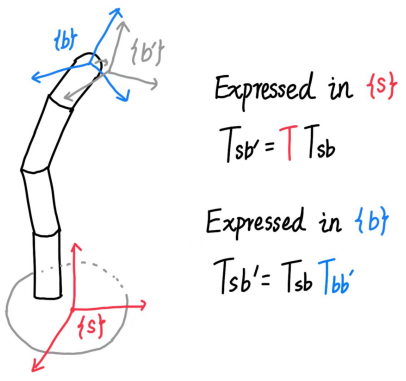

### 动作设计

#### 动作形式
关于 $\mathcal{V}_b$ 具体怎么作用于环境，有许多不同的形式。
<br>从坐标体系上，$\mathcal{V}_b$ 都是**相对**的，这避免了全局坐标系的影响，更有利于泛化。而 $\mathcal{V}_s$ 则与 $\{s\}$ 的选取有关，泛化性较差。
<br>第一种作用形式，是 $$T_{sb}\left(t+1\right)=T_{sb}\left(t\right)\exp\left(\left\lbrack\mathcal{V_{b}(t)}\right\rbrack\Delta t\right)$$
先将学到的旋量 $\mathcal{V}_b$ 通过指数投影为齐次变换矩阵增量，然后作用于当前的末端位姿 $T_{sb}(t)$，得到下一个时刻的末端位姿 $T_{sb}(t+1)$。然后由逆运动学求解出对应的关节位形 $\theta(t+1)$，作为环境的实际执行动作。
<br>第二种作用形式，为$$\theta\left(t+1\right)=\theta(t)+J_{b}^{+}\left(\theta\left(t\right)\right)\mathcal{V_{b}}\left(t\right)\Delta{t}$$
该形式来源于速度逆运动学与 **Newton-Raphson 方法**的迭代公式。这里无需通过**指数映射投影**，而是直接将旋量 $\mathcal{V}_b$ 通过雅可比矩阵的伪逆 $J_b^+$ 映射为关节空间的增量 $\Delta\theta(t+1)$，然后作用于当前关节位形 $\theta(t)$，得到下一个时刻的关节位形 $\theta(t+1)$，作为执行动作。这种形式更直接地将任务空间的动作映射到关节空间，而无需经过逆运动学求解过程。
<br>第二种形式有不同的变体：
* **DLS变体**：$$J_{dls}^{\dagger} = J^T (JJ^T + \lambda^2 I)^{-1}$$
  $$\theta\left(t+1\right)=\theta(t)+J_{b}^{+}\left(\theta\left(t\right)\right)\mathcal{V_{b}}\left(t\right)\Delta{t}$$
    该变体通过阻尼最小二乘法（Damped Least Squares）计算雅可比伪逆，增强了在奇异位形附近的稳定性，避免了数值不稳定问题。
* **PD控制变体**：在仿真和实际中，并不是直接将 $\Delta\theta(t+1)$ 作为执行动作，而是作为目标位置，结合PD控制器来计算实际的**关节力矩** $\tau$，这个力矩才是真正施加给底层控制器的命令。
\begin{gather}
\theta_{actual}\left(t\right)=\theta(t)\\ \dot{\theta}_{target}(t)=J_{b}^{+}\left(t\right)\mathcal{V}_{b}(t)\\ \theta_{target}\left(t+1\right)=\theta_{actual}(t)+\dot{\theta}_{target}(t)\Delta t\\ \tau=K_{p}\left(\theta_{target}\left(t+1\right)-\theta_{actual}\left(t\right)\right)+K_{d}\left(\dot{\theta}_{target}(t)-\dot{\theta}_{actual}\left(t\right)\right)
\end{gather}
该变体的合理性存疑，涉及时间系统约定，后续有待补充。后经过确认，该公式基本正确
<br>

#### 范围取舍
由于旋量 $\mathcal{V}_b$ 理论上无界，因此需要对其进行范围限制，以适应实际的机器人手指运动能力。
<br>首先 $\mathcal{V}_{b}=\begin{bmatrix}\omega_{b}\\ v_{b}\end{bmatrix}$，范围限制可分为对 $\omega_b$ 和 $v_b$ 两部分。

**角速度**
<br>对于角速度 $\omega_b$，有 $$\omega_{b}=\hat{\omega}\left|\right|\omega||=\hat{\omega}\frac{\Delta{\theta}}{\Delta{t}}=\hat{\omega}\frac{\pi}{k}$$这里是通过螺旋轴的旋转角来估算角速度大小，等价于 $\{b\}$ 每秒围绕绕螺旋轴转的最大度数 $|\frac{\pi}{k}|$。因为李代数旋量在 $\pi$ 处奇异，故每个时间步的旋转角 $\Delta{\theta}=\frac{\pi}{k}\Delta{t}$ 不能过大，$k$ 超参数便是调控该幅度范围的。

**线速度**
<br>对于线速度 $v_b$，有 $v_{b}=R_{}\dot{p}$。$v_b$ 是 $\{b\}$ 原点在 $\{b\}$ 下的线速度，因为 $\{b\}$ 一直在变化，故稍显不直观。而 $\dot{p}$ 则是 $\{b\}$ 原点在 $\{s\}$ 下的线速度，更直观。利用矩阵范数与向量范数的相容性，有
$$||v_{b}||_{\infty}=||R_{}\dot{p}||_{\infty}\leq\sqrt{3}||R_{}||_2||\dot{p}||_{\infty}=\sqrt{3}\sqrt{\lambda_{max}\left(R^{T}R\right)}\left|\right|\dot{p}\left|\right|_{\infty}=\sqrt{3}\left|\right|\dot{p}\left|\right|_{\infty}$$
因为旋转矩阵 $R$ 的2-范数为1，故可通过预估 $\dot{p}$ 的大小来间接设计 $v_b$ 的范围

## 任务设计

### 基准任务
可sim2real的可行场景任务

#### 手内精细操作
* **重定向任务**
<br>这个可结合IsaacLab现有环境：Isaac-Repose-Cube-Allegro-v0，还可改版为Leaphand手

* **手内旋转任务**
<br>这个可结合我/Leaphand官方的手内旋转任务环境

* **轨迹跟踪任务**
<br>可以新设有关

测评指标：末端物体位姿误差、成功率、平均完成步数

### 评判指标
- 通用指标有`成功率、效率（steps/time）、sample efficiency、鲁棒性、泛化性`
- baselines算法有PPO、SAC、TD3等
- ablations有  
1. Vision‑only（RGBD + proprio） vs Vision+simulated tactile（仿真 contact forces）。
2. With / Without ADR（域随机化）— 看 sim→real 成本。
3. Action type ablation：Position target vs Velocity vs Torque

### 高难度任务【后续可考虑】

#### 铰链对象操作
面向旋转阀门、开关、拿握使用剪刀、抽屉操作等，主要评估成功率、对未见对象（物理参数变化）的泛化能力


#### 长时序任务
面向多次 regrasp、组合搬运或 Rubik’s‑like 操作序列等，主要评估长期成功率、累积错误率、策略稳定性